# Description:
In this notebook we test the Top2Vec package API and we do some experiments.

In [1]:
# Make sure you have a GPU running
! nvidia-smi

Sun Aug  1 20:40:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   48C    P8     7W /  N/A |   1708MiB /  5934MiB |     19%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from haystack.document_store.elasticsearch import OpenDistroElasticsearchDocumentStore
import umap
import matplotlib.pyplot as plt

08/01/2021 20:40:02 - INFO - faiss.loader -   Loading faiss with AVX2 support.
08/01/2021 20:40:02 - INFO - faiss.loader -   Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
08/01/2021 20:40:02 - INFO - faiss.loader -   Loading faiss.
08/01/2021 20:40:02 - INFO - faiss.loader -   Successfully loaded faiss.
08/01/2021 20:40:02 - INFO - farm.modeling.prediction_head -   Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


In [3]:
import logging
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import umap
import hdbscan
import tempfile
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from top2vec import Top2Vec
from top2vec.Top2Vec import default_tokenizer

try:
    import hnswlib

    _HAVE_HNSWLIB = True
except ImportError:
    _HAVE_HNSWLIB = False

try:
    import tensorflow as tf
    import tensorflow_hub as hub
    import tensorflow_text

    _HAVE_TENSORFLOW = True
except ImportError:
    _HAVE_TENSORFLOW = False

try:
    from sentence_transformers import SentenceTransformer

    _HAVE_TORCH = True
except ImportError:
    _HAVE_TORCH = False

logger = logging.getLogger('top2vec')
logger.setLevel(logging.WARNING)
sh = logging.StreamHandler()
sh.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
logger.addHandler(sh)


class Top2Vec2(Top2Vec):
    def __init__(self,
                 documents,
                 min_count=50,
                 embedding_model='doc2vec',
                 embedding_model_path=None,
                 speed='learn',
                 use_corpus_file=False,
                 document_ids=None,
                 keep_documents=True,
                 workers=None,
                 tokenizer=None,
                 use_embedding_model_tokenizer=False,
                 umap_args=None,
                 hdbscan_args=None,
                 verbose=True
                 ):
        if verbose:
            logger.setLevel(logging.DEBUG)
            self.verbose = True
        else:
            logger.setLevel(logging.WARNING)
            self.verbose = False
        if tokenizer is None:
            tokenizer = default_tokenizer
        # validate documents
        if not (isinstance(documents, list) or isinstance(documents, np.ndarray)):
            raise ValueError("Documents need to be a list of strings")
        if not all((isinstance(doc, str) or isinstance(doc, np.str_)) for doc in documents):
            raise ValueError("Documents need to be a list of strings")
        if keep_documents:
            self.documents = np.array(documents, dtype="object")
        else:
            self.documents = None
        # validate document ids
        if document_ids is not None:
            if not (isinstance(document_ids, list) or isinstance(document_ids, np.ndarray)):
                raise ValueError("Documents ids need to be a list of str or int")
            if len(documents) != len(document_ids):
                raise ValueError("Document ids need to match number of documents")
            elif len(document_ids) != len(set(document_ids)):
                raise ValueError("Document ids need to be unique")
            if all((isinstance(doc_id, str) or isinstance(doc_id, np.str_)) for doc_id in document_ids):
                self.doc_id_type = np.str_
            elif all((isinstance(doc_id, int) or isinstance(doc_id, np.int_)) for doc_id in document_ids):
                self.doc_id_type = np.int_
            else:
                raise ValueError("Document ids need to be str or int")
            self.document_ids_provided = True
            self.document_ids = np.array(document_ids)
            self.doc_id2index = dict(zip(document_ids, list(range(0, len(document_ids)))))
        else:
            self.document_ids_provided = False
            self.document_ids = np.array(range(0, len(documents)))
            self.doc_id2index = dict(zip(self.document_ids, list(range(0, len(self.document_ids)))))
            self.doc_id_type = np.int_

        self.embedding_model_path = embedding_model_path
        if embedding_model == 'doc2vec':
            # validate training inputs
            if speed == "fast-learn":
                hs = 0
                negative = 5
                epochs = 40
            elif speed == "learn":
                hs = 1
                negative = 0
                epochs = 40
            elif speed == "deep-learn":
                hs = 1
                negative = 0
                epochs = 400
            elif speed == "test-learn":
                hs = 0
                negative = 5
                epochs = 1
            else:
                raise ValueError("speed parameter needs to be one of: fast-learn, learn or deep-learn")
            if workers is None:
                pass
            elif isinstance(workers, int):
                pass
            else:
                raise ValueError("workers needs to be an int")
            doc2vec_args = {"vector_size": 300,
                            "min_count": min_count,
                            "window": 15,
                            "sample": 1e-5,
                            "negative": negative,
                            "hs": hs,
                            "epochs": epochs,
                            "dm": 0,
                            "dbow_words": 1}
            if workers is not None:
                doc2vec_args["workers"] = workers
            logger.info('Pre-processing documents for training')
            if use_corpus_file:
                processed = [' '.join(tokenizer(doc)) for doc in documents]
                lines = "\n".join(processed)
                temp = tempfile.NamedTemporaryFile(mode='w+t')
                temp.write(lines)
                doc2vec_args["corpus_file"] = temp.name
            else:
                train_corpus = [TaggedDocument(tokenizer(doc), [i]) for i, doc in enumerate(documents)]
                doc2vec_args["documents"] = train_corpus
            logger.info('Creating joint document/word embedding')
            self.embedding_model = 'doc2vec'
            self.model = Doc2Vec(**doc2vec_args)
            if use_corpus_file:
                temp.close()
        else:
            self.embed = None
            self.embedding_model = embedding_model
            self._check_import_status()
            logger.info('Pre-processing documents for training')
            # preprocess documents (tokenizes and deaccents)
            tokenized_corpus = [tokenizer(doc) for doc in documents]  # the tokenizer is important here because we have to build a vocabulary
            def return_doc(doc):
                return doc
            # preprocess vocabulary
            vectorizer = CountVectorizer(tokenizer=return_doc, preprocessor=return_doc)
            doc_word_counts = vectorizer.fit_transform(tokenized_corpus)
            words = vectorizer.get_feature_names()
            word_counts = np.array(np.sum(doc_word_counts, axis=0).tolist()[0])
            vocab_inds = np.where(word_counts > min_count)[0]
            if len(vocab_inds) == 0:
                raise ValueError(f"A min_count of {min_count} results in "
                                 f"all words being ignored, choose a lower value.")
            self.vocab = [words[ind] for ind in vocab_inds]
            self._check_model_status()  # assigns self.embed
            logger.info('Creating joint document/word embedding')
            # embed words
            self.word_indexes = dict(zip(self.vocab, range(len(self.vocab))))
            self.word_vectors = self._l2_normalize(np.array(self.embed(self.vocab)))
            # embed documents
            if use_embedding_model_tokenizer:
                self.document_vectors = self._embed_documents(documents)
            else:
                train_corpus = [' '.join(tokens) for tokens in tokenized_corpus]
                self.document_vectors = self._embed_documents(train_corpus)

        # create 5D embeddings of documents
        logger.info('Creating lower dimension embedding of documents')
        if umap_args is None:
            umap_args = {'n_neighbors': 15,
                         'n_components': 5,
                         'metric': 'cosine'}
        umap_model = umap.UMAP(**umap_args).fit(self._get_document_vectors(norm=False))
        # find dense areas of document vectors
        logger.info('Finding dense areas of documents')
        if hdbscan_args is None:
            hdbscan_args = {'min_cluster_size': 15,
                             'metric': 'euclidean',
                             'cluster_selection_method': 'eom'}

        cluster = hdbscan.HDBSCAN(**hdbscan_args).fit(umap_model.embedding_)

        # save the UMAP and HDBSCAN model
        self.umap_model = umap_model
        self.cluster = cluster

        # calculate topic vectors from dense areas of documents
        logger.info('Finding topics')
        # create topic vectors
        self._create_topic_vectors(cluster.labels_)
        # deduplicate topics
        self._deduplicate_topics()
        # find topic words and scores
        self.topic_words, self.topic_word_scores = self._find_topic_words_and_scores(topic_vectors=self.topic_vectors)
        # assign documents to topic
        self.doc_top, self.doc_dist = self._calculate_documents_topic(self.topic_vectors,
                                                                      self._get_document_vectors())
        # calculate topic sizes
        self.topic_sizes = self._calculate_topic_sizes(hierarchy=False)
        # re-order topics
        self._reorder_topics(hierarchy=False)
        # initialize variables for hierarchical topic reduction
        self.topic_vectors_reduced = None
        self.doc_top_reduced = None
        self.doc_dist_reduced = None
        self.topic_sizes_reduced = None
        self.topic_words_reduced = None
        self.topic_word_scores_reduced = None
        self.hierarchy = None
        # initialize document indexing variables
        self.document_index = None
        self.serialized_document_index = None
        self.documents_indexed = False
        self.index_id2doc_id = None
        self.doc_id2index_id = None
        # initialize word indexing variables
        self.word_index = None
        self.serialized_word_index = None
        self.words_indexed = False
        
    def get_umap(self):
        """
        Get the UMAP model when the model is built.
        Returns
        -------
        umap_model: umap
        """
        return self.umap_model

    def get_hdbscan_cluster(self):
        """
        Get the HDBSCAN model when the model is built.
        Returns
        -------
        cluster: HDBSCAN
        """
        return self.cluster

    def _check_import_status(self):
        if self.embedding_model == "universal-sentence-encoder" or self.embedding_model == "universal-sentence-encoder-multilingual":
            if not _HAVE_TENSORFLOW:
                raise ImportError(f"{self.embedding_model} is not available.\n\n"
                                  "Try: pip install top2vec[sentence_encoders]\n\n"
                                  "Alternatively try: pip install tensorflow tensorflow_hub tensorflow_text")
        else:
            if not _HAVE_TORCH:
                raise ImportError(f"{self.embedding_model} is not available.\n\n"
                                  "Try: pip install top2vec[sentence_transformers]\n\n"
                                  "Alternatively try: pip install torch sentence_transformers")

    def _check_model_status(self):
        if self.embed is None:
            if self.verbose is False:
                logger.setLevel(logging.DEBUG)
            
            if self.embedding_model == "universal-sentence-encoder" or self.embedding_model == "universal-sentence-encoder-multilingual":
                if self.embedding_model_path is None:
                    logger.info(f'Downloading {self.embedding_model} model')
                    if self.embedding_model == "universal-sentence-encoder-multilingual":
                        module = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
                    else:
                        module = "https://tfhub.dev/google/universal-sentence-encoder/4"
                else:
                    logger.info(f'Loading {self.embedding_model} model at {self.embedding_model_path}')
                    module = self.embedding_model_path
                self.embed = hub.load(module)

            else:
                if self.embedding_model_path is None:
                    logger.info(f'Downloading {self.embedding_model} model')
                    module = self.embedding_model
                else:
                    logger.info(f'Loading {self.embedding_model} model at {self.embedding_model_path}')
                    module = self.embedding_model_path
                model = SentenceTransformer(module)
                self.embed = model.encode

        if self.verbose is False:
            logger.setLevel(logging.WARNING)

08/01/2021 20:40:03 - INFO - gensim.summarization.textcleaner -   'pattern' package not found; tag filters are not available for English


In [4]:
# Connect to ODElasticsearch instance (needs to be changed for security reasons)
document_store = OpenDistroElasticsearchDocumentStore(host='odfe-node1', 
                                                      username='admin', 
                                                      password='admin', 
                                                      scheme='https', 
                                                      verify_certs=False,
                                                      similarity='cosine',
                                                      return_embedding=True)
print(f"Document Store has {document_store.get_document_count()} documents.")

/usr/local/lib/python3.7/dist-packages/elasticsearch/connection/http_urllib3.py:206: UserWarning: Connecting to https://odfe-node1:9200 using SSL with verify_certs=False is insecure.
  % self.host
/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1006: InsecureRequestWarning: Unverified HTTPS request is being made to host 'odfe-node1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
08/01/2021 20:40:03 - INFO - elasticsearch -   HEAD https://odfe-node1:9200/ [status:200 request:0.056s]
/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1006: InsecureRequestWarning: Unverified HTTPS request is being made to host 'odfe-node1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
08/01/2021 20:40:03 - WARNING - elasticsearch -   PUT https://odfe-node1:9200/document

Document Store has 334921 documents.


In [5]:
# Get list of documents and categories
docs = []
categs = []
doc_gen = document_store.get_all_documents_generator(return_embedding=False)
for i, doc in enumerate(doc_gen):
    docs.append(doc.text)
    categs.append(doc.meta["category"])
    if i == 9999:
        break

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1006: InsecureRequestWarning: Unverified HTTPS request is being made to host 'odfe-node1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
08/01/2021 20:40:05 - INFO - elasticsearch -   POST https://odfe-node1:9200/document/_search?scroll=1d&size=10000 [status:200 request:0.101s]


In [6]:
# Get dictionary of unique categories
unique_categs = set(categs)
dict_uniques = dict(zip(unique_categs, range(len(unique_categs))))

In [7]:
for i in doc_gen:
    print(i)
    break

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1006: InsecureRequestWarning: Unverified HTTPS request is being made to host 'odfe-node1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
08/01/2021 16:39:37 - INFO - elasticsearch -   POST https://odfe-node1:9200/_search/scroll [status:200 request:0.138s]


{'text': 'Researchers Finally Figured Out How Octopuses Taste With Their Arms - Gizmodo Octopuses, with their eight suction-cup-covered arms, can taste objects simply by touching them. A team of researchers has finally figured out how these cephalopods are capable of pulling off this remarkable trick. Octopuses, with their eight suction-cup-covered arms, can taste objects simply by touching them. A team of researchers has finally figured out how these cephalopods are capable of pulling off this re', 'id': '899973a9-5462-482b-a7b2-8d914041e452', 'score': None, 'probability': None, 'question': None, 'meta': {'source': None, 'author': 'George Dvorsky', 'publishedat': '2020-10-29T15:07:00Z', 'url': 'https://gizmodo.com/researchers-finally-figured-out-how-octopuses-taste-wit-1845517269', 'urltoimage': 'https://i.kinja-img.com/gawker-media/image/upload/c_fill,f_auto,fl_progressive,g_center,h_675,pg_1,q_80,w_1200/f8yzsyplqhdk2imhkl0m.jpg', 'category': 'science'}, 'embedding': None}


## Top2Vec - 5d UMAP + 2d UMAP

In [8]:
# Top2vec model - 5d UMAP
model = Top2Vec2(docs, embedding_model="sentence-transformers/msmarco-distilbert-base-v4")

# Reduce the number of topics discovered by Top2Vec
model.hierarchical_topic_reduction(20)
model.get_topic_hierarchy()

2021-08-01 16:39:37,289 - top2vec - INFO - Pre-processing documents for training
2021-08-01 16:39:37,289 - top2vec - INFO - Pre-processing documents for training
08/01/2021 16:39:37 - INFO - top2vec -   Pre-processing documents for training
2021-08-01 16:39:38,894 - top2vec - INFO - Downloading sentence-transformers/msmarco-distilbert-base-v4 model
2021-08-01 16:39:38,894 - top2vec - INFO - Downloading sentence-transformers/msmarco-distilbert-base-v4 model
08/01/2021 16:39:38 - INFO - top2vec -   Downloading sentence-transformers/msmarco-distilbert-base-v4 model
08/01/2021 16:39:38 - INFO - sentence_transformers.SentenceTransformer -   Load pretrained SentenceTransformer: sentence-transformers/msmarco-distilbert-base-v4
08/01/2021 16:39:38 - INFO - sentence_transformers.SentenceTransformer -   Did not find folder sentence-transformers/msmarco-distilbert-base-v4
08/01/2021 16:39:38 - INFO - sentence_transformers.SentenceTransformer -   Search model on server: http://sbert.net/models/sen

Batches:   0%|          | 0/58 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2021-08-01 16:40:07,632 - top2vec - INFO - Creating lower dimension embedding of documents
2021-08-01 16:40:07,632 - top2vec - INFO - Creating lower dimension embedding of documents
08/01/2021 16:40:07 - INFO - top2vec -   Creating lower dimension embedding of documents
2021-08-01 16:40:22,818 - top2vec - INFO - Finding dense areas of documents
2021-08-01 16:40:22,818 - top2vec - INFO - Finding dense areas of documents
08/01/2021 16:40:22 - INFO - top2vec -   Finding dense areas of documents
2021-08-01 16:40:23,025 - top2vec - INFO - Finding topics
2021-08-01 16:40:23,025 - top2vec - INFO - Finding topics
08/01/2021 16:40:23 - INFO - top2vec -   Finding topics


[[16, 62, 26, 63, 58, 41, 81, 5],
 [40, 22, 65, 70, 1],
 [42, 32, 60, 83, 0],
 [35, 69, 79, 80, 3],
 [57, 18, 67, 45, 71, 46, 61, 7],
 [37, 47, 30, 28, 11],
 [27, 50, 82, 6],
 [77, 24, 15, 34, 43, 86, 64, 55, 66, 44],
 [2],
 [52, 23, 59, 78, 84, 76, 74, 39],
 [51, 12, 73, 72, 13],
 [53, 49, 25, 19, 68, 29],
 [21, 38, 85, 54, 33],
 [31, 14],
 [9],
 [4],
 [36, 48, 17],
 [56, 75, 20],
 [8],
 [10]]

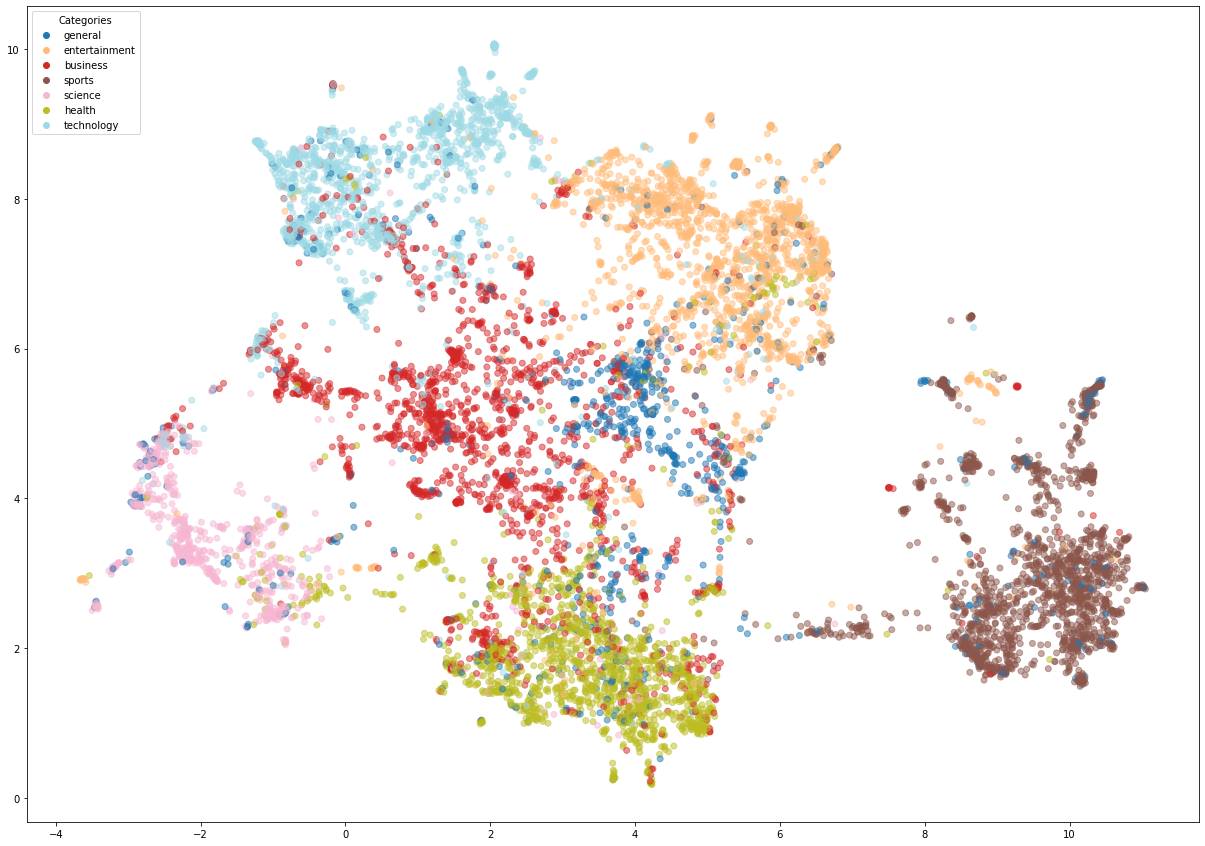

In [9]:
# Do we even need to reduce to 2 dimensions? Can we just look for the best 2D subspace?
# Reduce to 2 dimensions
umap_args = {'n_neighbors': 15,
             'n_components': 2,
             'metric': 'cosine'}
data = umap.UMAP(**umap_args).fit_transform(model.document_vectors)

# Plot 2d embeddings with category labels
fig, ax = plt.subplots(figsize=(21,15))

scatter = ax.scatter(data[:, 0], data[:, 1], alpha=0.5, c=list(map(lambda x: dict_uniques[x], categs)), cmap="tab20")

# produce a legend with the unique colors from the scatter
handles, _ = scatter.legend_elements(num=None,  alpha=1)
legend1 = ax.legend(handles, unique_categs, ncol=1, loc="upper left", title="Categories")

plt.show()

In [10]:
# Get topic words
topic_words, word_scores, topic_nums = model.get_topics(20, reduced=True)

# Produce topic labels by concatenating top 5 words
topic_labels = ["_".join(words[:5]) for words in topic_words]

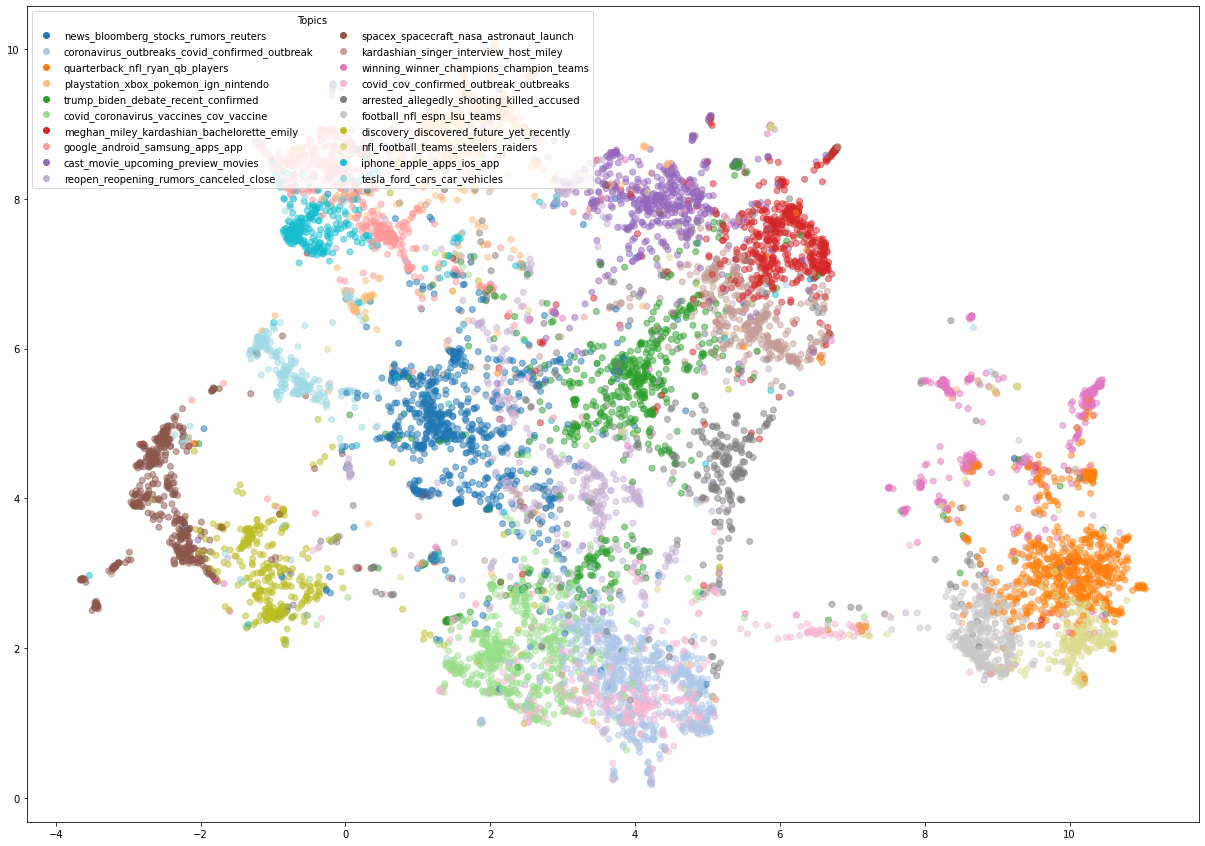

In [11]:
# Plot 2d embeddings with reduced topic labels
fig, ax = plt.subplots(figsize=(21,15))

scatter = ax.scatter(data[:, 0], data[:, 1], alpha=0.5, c=model.doc_top_reduced, cmap="tab20")

# produce a legend with the unique colors from the scatter
handles, _ = scatter.legend_elements(num=None,  alpha=1)
legend1 = ax.legend(handles, topic_labels, ncol=2, loc="upper left", title="Topics")

plt.show()

## Top2Vec - 2d UMAP

In [12]:
# Top2vec model
umap_args = {'n_neighbors': 15,
             'n_components': 2,
             'metric': 'cosine'}
model = Top2Vec2(docs, embedding_model="sentence-transformers/msmarco-distilbert-base-v4", umap_args=umap_args)

# Reduce the number of topics discovered by Top2Vec
model.hierarchical_topic_reduction(20)
model.get_topic_hierarchy()

2021-08-01 16:40:31,796 - top2vec - INFO - Pre-processing documents for training
2021-08-01 16:40:31,796 - top2vec - INFO - Pre-processing documents for training
08/01/2021 16:40:31 - INFO - top2vec -   Pre-processing documents for training
2021-08-01 16:40:33,496 - top2vec - INFO - Downloading sentence-transformers/msmarco-distilbert-base-v4 model
2021-08-01 16:40:33,496 - top2vec - INFO - Downloading sentence-transformers/msmarco-distilbert-base-v4 model
08/01/2021 16:40:33 - INFO - top2vec -   Downloading sentence-transformers/msmarco-distilbert-base-v4 model
08/01/2021 16:40:33 - INFO - sentence_transformers.SentenceTransformer -   Load pretrained SentenceTransformer: sentence-transformers/msmarco-distilbert-base-v4
08/01/2021 16:40:33 - INFO - sentence_transformers.SentenceTransformer -   Did not find folder sentence-transformers/msmarco-distilbert-base-v4
08/01/2021 16:40:33 - INFO - sentence_transformers.SentenceTransformer -   Search model on server: http://sbert.net/models/sen

Batches:   0%|          | 0/58 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2021-08-01 16:41:00,034 - top2vec - INFO - Creating lower dimension embedding of documents
2021-08-01 16:41:00,034 - top2vec - INFO - Creating lower dimension embedding of documents
08/01/2021 16:41:00 - INFO - top2vec -   Creating lower dimension embedding of documents
2021-08-01 16:41:06,850 - top2vec - INFO - Finding dense areas of documents
2021-08-01 16:41:06,850 - top2vec - INFO - Finding dense areas of documents
08/01/2021 16:41:06 - INFO - top2vec -   Finding dense areas of documents
2021-08-01 16:41:06,983 - top2vec - INFO - Finding topics
2021-08-01 16:41:06,983 - top2vec - INFO - Finding topics
08/01/2021 16:41:06 - INFO - top2vec -   Finding topics


[[18, 74, 26, 52, 0],
 [33, 87, 1],
 [60, 57, 31, 49, 54, 61, 67, 82, 4],
 [72, 30, 42, 59, 63, 5],
 [13, 81, 29, 55, 85, 14],
 [36, 21, 88, 32, 23, 80, 76, 17],
 [47, 58, 39, 65, 22, 19, 62, 48, 69, 20],
 [68, 16, 89, 45, 44, 66, 70, 9],
 [75, 73, 3],
 [15, 50, 51, 11],
 [2],
 [78, 28, 34, 35],
 [6],
 [83, 40, 43, 84, 53, 25],
 [27, 64, 86, 38],
 [41, 7],
 [24, 37, 71, 56],
 [8],
 [46, 12],
 [79, 77, 10]]

In [13]:
model.get_hdbscan_cluster().labels_

array([18,  4, 71, ..., 78, 72, -1])

In [14]:
model.topic_vectors.shape

(90, 768)

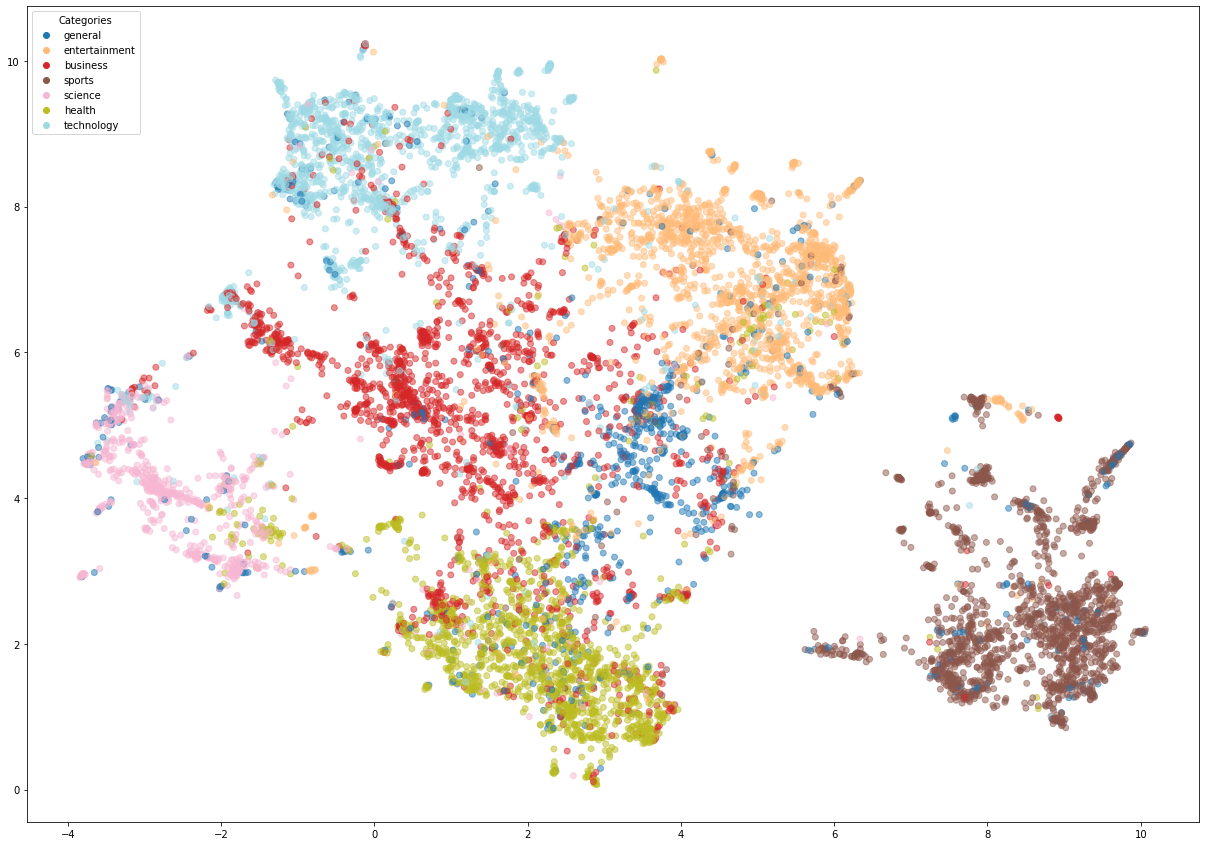

In [15]:
# Plot 2d embeddings with category labels
data = model.get_umap().embedding_

fig, ax = plt.subplots(figsize=(21,15))

scatter = ax.scatter(data[:, 0], data[:, 1], alpha=0.5, c=list(map(lambda x: dict_uniques[x], categs)), cmap="tab20")

# produce a legend with the unique colors from the scatter
handles, _ = scatter.legend_elements(num=None,  alpha=1)
legend1 = ax.legend(handles, unique_categs, ncol=1, loc="upper left", title="Categories")

plt.show()

In [16]:
# Get topic words
topic_words, word_scores, topic_nums = model.get_topics(20, reduced=True)

# Produce topic labels by concatenating top 5 words
topic_labels = ["_".join(words[:5]) for words in topic_words]

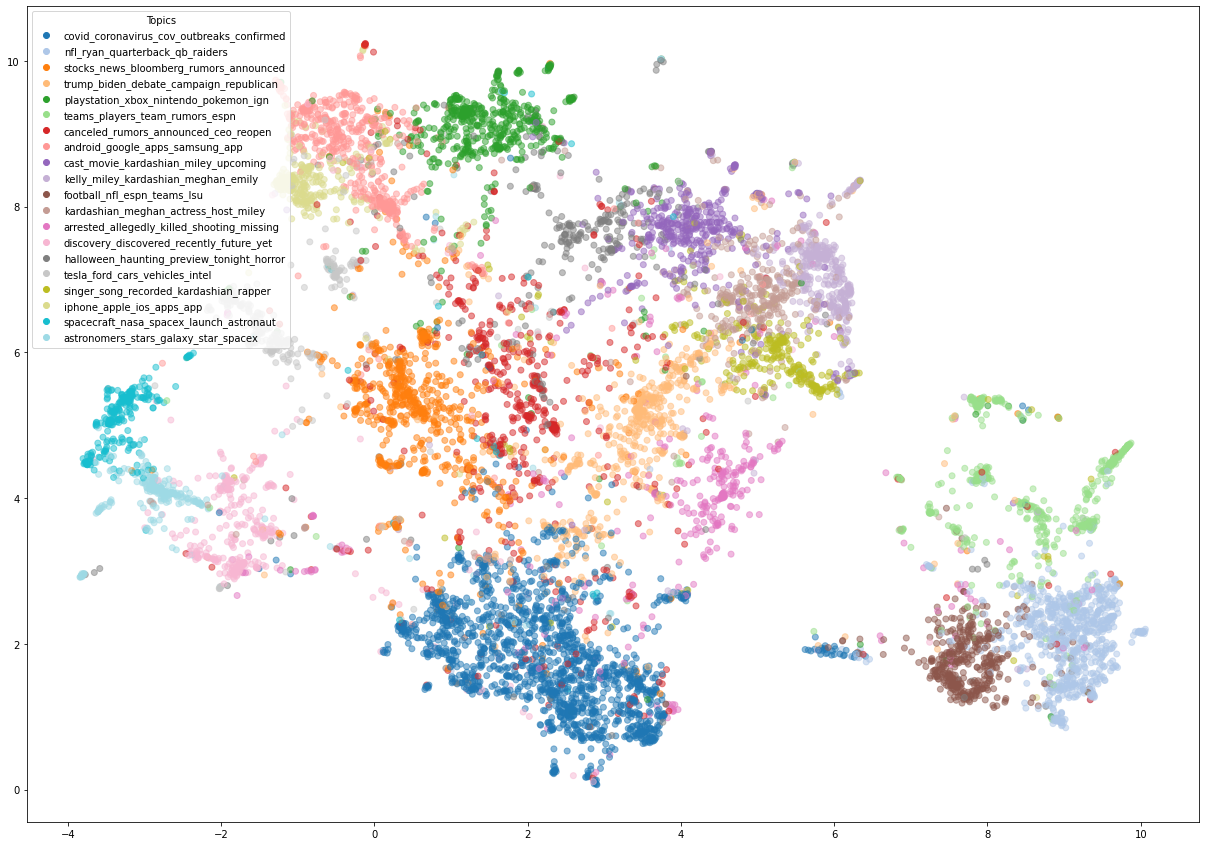

In [17]:
# Plot 2d embeddings with reduced topic labels
fig, ax = plt.subplots(figsize=(21,15))

scatter = ax.scatter(data[:, 0], data[:, 1], alpha=0.5, c=model.doc_top_reduced, cmap="tab20")

# produce a legend with the unique colors from the scatter
handles, _ = scatter.legend_elements(num=None,  alpha=1)
legend1 = ax.legend(handles, topic_labels, ncol=1, loc="upper left", title="Topics")

plt.show()

### Some conclusions from the previous sections:
- Top2Vec on 5 dimensions might achieve better topics than on 2 dimensions, however it comes with the cost of not being visualized. To solve this we can further reduce the space to 2 dimensions (the results weren't good) or we can look for a 2 dimensional subspace that represents the data well (i.e. has good separation between clusters).


## Exploring Top2Vec API

In [18]:
# How many topics there are?
num_topics = model.get_num_topics()
num_topics

90

In [19]:
# What are the topics about?
topic_words, word_scores, topic_nums = model.get_topics(num_topics)

In [20]:
topic_words

array([['covid', 'coronavirus', 'cov', ..., 'cases', 'cancer',
        'currently'],
       ['nfl', 'ryan', 'quarterback', ..., 'thursday', 'offensive',
        'week'],
       ['football', 'nfl', 'espn', ..., 'division', 'monday', 'win'],
       ...,
       ['ryan', 'quarterback', 'nfl', ..., 'sunday', 'wwe', 'response'],
       ['ahead', 'tony', 'stage', ..., 'rocket', 'results', 'motley'],
       ['apps', 'youtube', 'techcrunch', ..., 'version', 'ceo', 'latest']],
      dtype='<U13')

In [21]:
# Search topics based on a keyword
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["apple"], num_topics=5)

In [22]:
topic_nums

array([ 8, 22,  9, 16, 70])

In [23]:
# Search documents by topic 3
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=3, num_docs=5)

In [24]:
documents

array(["Netflix unveils first look at American Horror Story boss's new movie with Meryl Streep and James Corden - digitalspy.com Talk about star-studded. Meryl Streep and James Corden are reuniting after Into the Woods for a new musical adaptation, and this time it's a Netflix exclusive produced by Ryan Murphy.The Prom will feature the duo alongside",
       'Netflix to Campaign Chadwick Boseman as Lead Actor for ‘Ma Rainey’s Black Bottom’ - Variety As the Oscar season continues to unfold, a new question has been answered for the upcoming awards circuit. Netflix has confirmed to Variety that it will campaign the late Chadwick Boseman in the lead actor category for his role in the upcoming “Ma Rainey’s Bl As the Oscar season continues to unfold, a new question has been answered for the upcoming awards circuit. Netflix has confirmed to Variety that it will campaign the late Chadwick Boseman in the lead',
       "Nicole Kidman Previews 'The Undoing,' Talks 'Big Little Lies' Season 3 - TVL

In [25]:
# Semantic search of documents using keywords
documents, document_scores, document_ids = model.search_documents_by_keywords(keywords=["Apple"], num_docs=5)

In [26]:
document_ids

array([7231,  228, 1146, 1934, 4377])

In [27]:
documents

array(['Apple MacBook with ARM processor could arrive in November - TechRadar Might this be Apple’s most affordable MacBook in years? Apples first Mac with an ARM processor will be a laptop, and itll be launched in November according to the latest from the rumor mill.This comes from a Bloomberg report by Mark Gurman, a well-known',
       'Apple Brings the New-Generation Apple Maps Experience to More Users - autoevolution Apple originally announced a major Apple Maps overhaul earlier this year, but at that point, the new capabilities, which included more accurate navigation and updated imagery, was only available in the United States and a handful of other regions. The Cupertino-based tech giant, however, gradually increased the availability of this update, and last month, the new Apple Maps experience silently went live in the United Kingdom too.However, Apple',
       'Apple Music TV launches as MTV-style 24-hour music video stream - 9to5Mac Apple Music TV has been launched today, as

In [28]:
# Get document topics - 376 talks about Appple M1 Mac
model.get_documents_topics([376])

(array([5]),
 array([0.45771527], dtype=float32),
 array([['trump', 'biden', 'campaign', 'debate', 'republican', 'recent',
         'interview', 'reportedly', 'host', 'announced', 'donald', 'ceo',
         'news', 'kyle', 'democrats', 'mr', 'allegedly', 'recently',
         'ryan', 'winning', 'bloomberg', 'candidate', 'controversial',
         'espn', 'talks', 'cohen', 'asked', 'confirmed', 'mayor',
         'nominee', 'yesterday', 'cnn', 'davis', 'rumors', 'ron',
         'comments', 'cup', 'not', 'wins', 'currently', 'announcement',
         'instead', 'democratic', 'revealed', 'kardashian', 'mike',
         'president', 'morgan', 'held', 'scott']], dtype='<U13'),
 array([[0.503106  , 0.42046532, 0.3151339 , 0.26692584, 0.2580449 ,
         0.2373524 , 0.23073527, 0.22800316, 0.22374606, 0.2103087 ,
         0.20757565, 0.20355108, 0.20320433, 0.20141949, 0.19967845,
         0.19827396, 0.19341554, 0.19244006, 0.19124019, 0.19113031,
         0.1911136 , 0.19045237, 0.19000535, 0.18

In [29]:
# Reduce the number of topics discovered by Top2Vec.
model.hierarchical_topic_reduction(20)
model.get_topic_hierarchy()

[[18, 74, 26, 52, 0],
 [33, 87, 1],
 [60, 57, 31, 49, 54, 61, 67, 82, 4],
 [72, 30, 42, 59, 63, 5],
 [13, 81, 29, 55, 85, 14],
 [36, 21, 88, 32, 23, 80, 76, 17],
 [47, 58, 39, 65, 22, 19, 62, 48, 69, 20],
 [68, 16, 89, 45, 44, 66, 70, 9],
 [75, 73, 3],
 [15, 50, 51, 11],
 [2],
 [78, 28, 34, 35],
 [6],
 [83, 40, 43, 84, 53, 25],
 [27, 64, 86, 38],
 [41, 7],
 [24, 37, 71, 56],
 [8],
 [46, 12],
 [79, 77, 10]]

In [30]:
# What are the topics about?
topic_words, word_scores, topic_nums = model.get_topics(num_topics)

In [31]:
topic_words[[68, 17, 32, 59, 69, 4]]

array([['amazon', 'prime', 'google', 'cnn', 'markets', 'selling',
        'sales', 'event', 'com', 'events', 'cnbc', 'anticipated', 'news',
        'sunday', 'holiday', 'wilson', 'nov', 'market', 'verizon', 'oct',
        'interest', 'sale', 'day', 'sell', 'shopping', 'techcrunch',
        'buy', 'march', 'schedule', 'matchup', 'announced', 'america',
        'kate', 'tuesday', 'stores', 'bank', 'sold', 'netflix', 'due',
        'bloomberg', 'target', 'celebrate', 'held', 'save',
        'marketwatch', 'ahead', 'expected', 'morning', 'universal',
        'ceo'],
       ['dodgers', 'astros', 'mlb', 'braves', 'teams', 'espn', 'team',
        'winning', 'raiders', 'players', 'games', 'cardinals', 'game',
        'winner', 'rumors', 'questions', 'champions', 'kyle', 'asked',
        'cohen', 'player', 'wins', 'giants', 'champion', 'joe', 'nfl',
        'win', 'davis', 'won', 'nintendo', 'houston', 'nascar', 'fans',
        'league', 'division', 'jim', 'controversial', 'picks', 'stadium',
 

In [32]:
# Semantic search of documents using a query
# model.query_documents("Apple", 5)

In [33]:
# Accessing the document vectors.
model.document_vectors

array([[ 0.03245978,  0.00054774, -0.0525041 , ...,  0.05163728,
        -0.00030704, -0.11431397],
       [ 0.01325147, -0.01405319, -0.05793538, ..., -0.04829096,
         0.05589253,  0.00042155],
       [-0.01201193,  0.01352049,  0.05366463, ...,  0.03021606,
         0.03336469, -0.0175691 ],
       ...,
       [-0.00698659, -0.03247255,  0.00266446, ...,  0.03227857,
         0.05478002, -0.07307563],
       [ 0.0204547 , -0.04904286,  0.00403683, ...,  0.02472927,
         0.00938098, -0.0091599 ],
       [-0.03702969,  0.02535968,  0.03092176, ..., -0.0205758 ,
        -0.01852337, -0.02676014]], dtype=float32)

In [34]:
model._get_document_vectors()

array([[ 0.03245978,  0.00054774, -0.0525041 , ...,  0.05163728,
        -0.00030704, -0.11431397],
       [ 0.01325147, -0.01405319, -0.05793538, ..., -0.04829096,
         0.05589253,  0.00042155],
       [-0.01201193,  0.01352049,  0.05366463, ...,  0.03021606,
         0.03336469, -0.0175691 ],
       ...,
       [-0.00698659, -0.03247255,  0.00266446, ...,  0.03227857,
         0.05478002, -0.07307563],
       [ 0.0204547 , -0.04904286,  0.00403683, ...,  0.02472927,
         0.00938098, -0.0091599 ],
       [-0.03702969,  0.02535968,  0.03092176, ..., -0.0205758 ,
        -0.01852337, -0.02676014]], dtype=float32)

In [35]:
# Topic assignment
model.doc_top

array([ 1, 18, 38, ..., 24,  3, 41])

In [36]:
# Reduced topics assignment (after hierarchical reduction)
model.doc_top_reduced

array([ 1,  1, 14, ..., 16,  8,  7])